### (1) Import

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
# from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets as dset
import matplotlib.pyplot as plt
torch.manual_seed(0)

### (2) Generator

In [ ]:

class Generator(nn.Module):
  def __init__(self, input_dim=10, in_chan=3, hidden_dim=32):
    super(Generator, self).__init__()
    self.input_dim = input_dim
    # Build the neural network
    self.gen = nn.Sequential(
        self.gen_block(input_dim, hidden_dim * 8, stride = 1, padding = 0), 
        self.gen_block(hidden_dim * 8, hidden_dim * 4), 
        self.gen_block(hidden_dim * 4, hidden_dim * 2), 
        self.gen_block(hidden_dim * 2, hidden_dim), 
        self.gen_block(hidden_dim, in_chan, final_layer=True)
    )

  # def gen_block
  def gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, dilation = 1, output_padding = 0, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, output_padding = output_padding),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True),
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, output_padding = output_padding),
          nn.Tanh(), # tanh => -1 ~ 1까지 나오므로 값을 제한하기 위해 사용함
      )

  def unsqueeze_noise(self, noise):
    return noise.view(len(noise), self.input_dim, 1, 1)

  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

### (3) Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, im_chan=13, hidden_dim=16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.disc_block(im_chan, hidden_dim),
        self.disc_block(hidden_dim, hidden_dim * 2),
        self.disc_block(hidden_dim*2, hidden_dim*4),
        self.disc_block(hidden_dim*4, hidden_dim*8),
        self.disc_block(hidden_dim*8, 1, final_layer = True),
    )

  # def disc_block
  def disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2, inplace=True)
      )
    else:  # Final layer
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=0)
      )

  def forward(self, image):
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred), -1)

### (4) Noise 생성

In [ ]:
def get_noise(n_samples, input_dim, device="cpu"):
  return torch.randn(n_samples, input_dim, device=device)

### (5) 초기화

In [ ]:
import torch.nn.functional as F
def get_one_Hot_labels(labels, n_clases):
  return F.one_hot(labels, n_classes)

def combine_vectors(x, y):
  combined = torch.cat((x.float(), y.float()), 1)
  return combined

In [ ]:
celeba_shape = (3, 64, 64)
n_classes = 2

criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = "cpu"

### (5-1) 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root = '/content/drive/MyDrive/dataset'

image_size = 64
batch_size = 128

celeba_data = dset.CelebA(data_root,
                          download=True,
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])                                                     
                          ]))
dataloader = torch.utils.data.DataLoader(celeba_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


### (5-3) optimizer

In [ ]:
def get_input_dimensions(z_dim, celeba_shape, n_classes):
    generator_input_dim= z_dim + n_classes
    discriminator_im_chan = celeba_shape[0] + n_classes
    
    return generator_input_dim, discriminator_im_chan

In [ ]:
generator_input_dim, discriminator_im_chan = get_input_dimensions (z_dim, celeba_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  if sys.path[0] == '':


### (5-2) one-hot-encoder 사용안할 경우

In [ ]:
# alabels : 여자만 0
# blables : 여자만 1
# 이 2개를 합쳐서 (128,2)를 만드는 것이 목표

# cur_step = 0
# generator_losses = []
# discriminator_losses = []

# noise_and_labels = False
# fake = False

# fake_image_and_labels = False
# real_image_and_labels = False
# disc_fake_pred = False
# disc_real_pred = False

# for epoch in range(n_epochs):
#     for real, tlabels in tqdm(dataloader):
#         alabels = tlabels[:,21]
#         blabels = ~alabels+2
#         labels = torch.stack([alabels, blabels], dim=1)


### (6) image display

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1,28,28), nrow=5, show=True):
  image_tensor = (image_tensor + 1) / 2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
  plt.imshow(image_grid.permute(1,2,0).squeeze())
  if show:
    plt.show()

### (7) training

Congraturations.
Step 500: Generator loss: 4.030990680217743, Discriminator loss: 0.17128499506413936


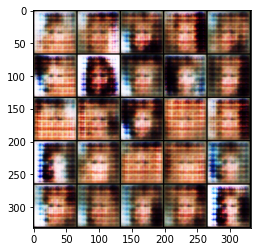

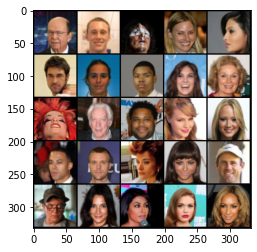

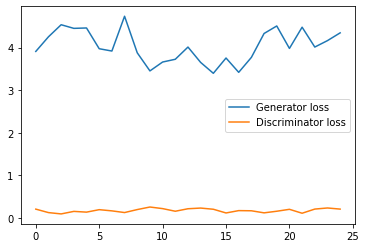

KeyboardInterrupt: ignored

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
        labels = tlabels[:, 21] # 21번째 label이 male or not
        cur_batch_size = len(real)
        real = real.to(device)
        
        # upgrade discriminator
        one_hot_labels = get_one_Hot_labels(labels.to(device), n_classes)

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, celeba_shape[1], celeba_shape[2])

        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels) # (G(z|y))
        real_image_and_labels = combine_vectors(real, image_one_hot_labels) # x|y

        disc_fake_pred = disc(fake_image_and_labels.detach()) # D(G(z|y))
        disc_real_pred = disc(real_image_and_labels) # D(x|y)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss)/2
        
        # track the average disc loss
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses += [disc_loss.item()]
        
        # update generator
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # track the average gen loss
        generator_losses += [gen_loss.item()]

#         if test_generator:
#             try:
#                 assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch ==0)
#                 assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
#             except:
#                 error=True
#                 print("Runtime tests have failed")

        # visualize the results
    
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, Discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i*step_bins for i in range(len(generator_losses)//step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot (
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label = "Generator loss"
            )
            plt.plot (
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label = "Discriminator loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congraturations.")
        cur_step += 1
                                  